In [4]:
!pip install numpy pandas scikit-learn nltk tensorflow transformers

In [5]:
import pandas as pd

# Load both datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# Add a label column: 1 for Fake, 0 for True
fake_df['label'] = 1
true_df['label'] = 0

# Combine the two datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the data to mix fake and real news
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the combined data
df.head()



,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


In [6]:
# Drop unnecessary columns
df = df.drop(columns=['subject', 'date'], errors='ignore')  # Will only drop if they exist

# Combine 'title' and 'text' columns
df['combined_text'] = df['title'] + " " + df['text']

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    return " ".join(filtered_words)

# Apply to combined text
df['clean_text'] = df['combined_text'].apply(preprocess_text)

# Check a few cleaned entries
df[['clean_text', 'label']].head()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,clean_text,label
0,ben stein calls 9th circuit court committed co...,1
1,trump drops steve bannon national security cou...,0
2,puerto rico expects u lift jones act shipping ...,0
3,oops trump accidentally confirmed leaked israe...,1
4,donald trump heads scotland reopen golf resort...,0


In [7]:
from sklearn.model_selection import train_test_split

# Features and Labels
X = df['clean_text']
y = df['label']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on training data, transform both train and test
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate
print("📊 Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


📊 Naive Bayes
Accuracy: 0.9316258351893095
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4270
           1       0.93      0.94      0.93      4710

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



In [9]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate
print("\n📊 Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))



📊 Logistic Regression
Accuracy: 0.9867483296213808
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4270
           1       0.99      0.98      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



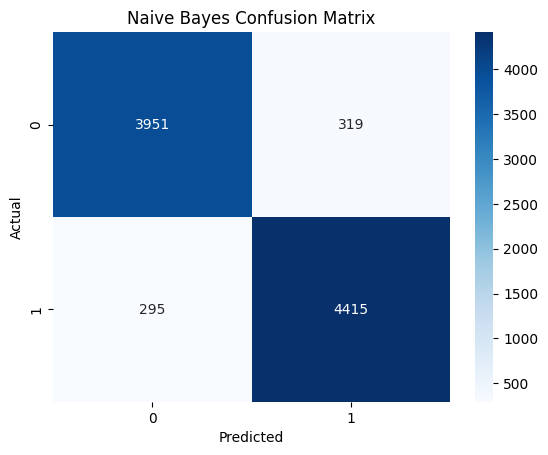

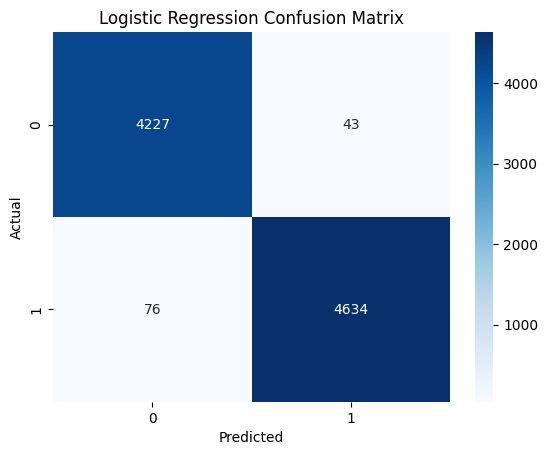

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")
plot_confusion(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")


In [11]:
import joblib

# Save the model and vectorizer
joblib.dump(lr_model, "logistic_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [14]:
# Install necessary packages
!pip install flask pyngrok joblib

# Create app.py
flask_code = """
from flask import Flask, request, render_template
import joblib

# Load model and vectorizer
model = joblib.load("logistic_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        news_text = request.form['news']
        transformed_text = vectorizer.transform([news_text])
        prediction = model.predict(transformed_text)
        result = "Fake News ❌" if prediction[0] == 1 else "Real News ✅"
        return render_template('index.html', prediction=result)

if __name__ == '__main__':
    app.run()
"""
with open("app.py", "w") as f:
    f.write(flask_code)

# Create templates directory and index.html
import os
os.makedirs("templates", exist_ok=True)

html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Fake News Detector</title>
</head>
<body style="font-family: Arial; text-align: center; padding: 30px;">
  <h1>📰 Fake News Detector</h1>
  <form action="/predict" method="POST">
    <textarea name="news" rows="10" cols="80" placeholder="Paste your news article here..." required></textarea><br><br>
    <input type="submit" value="Check News">
  </form>
  {% if prediction %}
    <h2>Prediction: {{ prediction }}</h2>
  {% endif %}
</body>
</html>
"""
with open("templates/index.html", "w") as f:
    f.write(html_code)


In [15]:
# Start ngrok tunnel
from pyngrok import ngrok, conf
conf.get_default().auth_token = "2qeIz8xwbmkRt4vC5FNcR7LmeCF_37N4zvtjf3vRg5DKtGmVs"
ngrok.kill()
public_url = ngrok.connect(5000)
print("🌐 Public URL:", public_url)

# Run Flask app in the background
!nohup flask run --host=0.0.0.0 --port=5000 &
!tail -n 50 nohup.out

🌐 Public URL: NgrokTunnel: "https://1e1b-35-188-188-17.ngrok-free.app" -> "http://localhost:5000"
nohup: appending output to 'nohup.out'
Traceback (most recent call last):
  File "/usr/local/bin/flask", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/cli.py", line 1129, in main
    cli.main()
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1082, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1697, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1443, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 788, in invoke
    return __callback(*args,